In [1]:
# use float64'
from jax import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import jaxley as jx

from jaxley.channels.hh import HH
import matplotlib.pyplot as plt

import optax
from jaxley.optimize.transforms import ParamTransform, SigmoidTransform

In [28]:
comp = jx.Compartment()
comp.insert(HH())
comp.set("v", -65.0)
comp.init_states()
comp.record()

dt = 0.025
tspan = (0, 50)
ts = jnp.arange(tspan[0], tspan[-1], dt)
stim = jx.step_current(10, 30, 0.005, dt, tspan[-1])
comp.stimulate(stim)

v_target = jx.integrate(comp)[0, ::4]

Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


In [36]:
from jaxley.optimize.transforms import Transform
from jax.typing import ArrayLike
from jax import Array

from jaxley.solver_gate import save_exp


class SigmoidTransform(Transform):
    """Sigmoid transformation."""

    def __init__(self, lower: ArrayLike, upper: ArrayLike) -> None:
        """This transform maps any value bijectively to the interval [lower, upper].

        Args:
            lower (ArrayLike): Lower bound of the interval.
            upper (ArrayLike): Upper bound of the interval.
        """
        super().__init__()
        self.lower = lower
        self.width = upper - lower

    def forward(self, x: ArrayLike) -> Array:
        y = 1.0 / (1.0 + save_exp(-x))
        return self.lower + self.width * y

    def inverse(self, y: ArrayLike) -> Array:
        x = (y - self.lower) / self.width
        x = -jnp.log((1.0 / x) - 1.0)
        return x


class LogisticTransform(SigmoidTransform):
    """Logistic transformation."""

    def __init__(self, lower: ArrayLike, upper: ArrayLike) -> None:
        """This transform maps any value bijectively to the interval [lower, upper].

        Args:
            lower (ArrayLike): Lower bound of the interval.
            upper (ArrayLike): Upper bound of the interval.
        """
        super().__init__(lower, upper)

    def forward(self, x: ArrayLike) -> Array:
        x_logit = x * jnp.pi / jnp.sqrt(3)  # rescale (logistic has variance π²/3)
        return super().forward(x_logit)

    def inverse(self, y: ArrayLike) -> Array:
        x_logit = super().inverse(y)
        return x_logit * jnp.sqrt(3) / jnp.pi  # Scale to unit variance

Number of newly added trainable parameters: 1. Total number of trainable parameters: 1
Number of newly added trainable parameters: 1. Total number of trainable parameters: 2
Number of newly added trainable parameters: 1. Total number of trainable parameters: 3
Step 0: Loss = 35.139990
Step 100: Loss = 1.521410
Step 200: Loss = 0.968084
Step 300: Loss = 0.742453
Step 400: Loss = 0.635449
Step 500: Loss = 0.562420
Step 600: Loss = 0.496490
Step 700: Loss = 0.431733
Step 800: Loss = 0.368504
Step 900: Loss = 0.308538
Step 1000: Loss = 0.253508
Step 1100: Loss = 0.204601
Step 1200: Loss = 0.162409
Step 1300: Loss = 0.126971
Step 1400: Loss = 0.097900
Step 1500: Loss = 0.074535
Step 1600: Loss = 0.056086
Step 1700: Loss = 0.041739
Step 1800: Loss = 0.030730
Step 1900: Loss = 0.022385
Step 0: Loss = 35.139990
Step 100: Loss = 1.165662
Step 200: Loss = 0.722091
Step 300: Loss = 0.582308
Step 400: Loss = 0.480499
Step 500: Loss = 0.383051
Step 600: Loss = 0.293166
Step 700: Loss = 0.215996
Ste

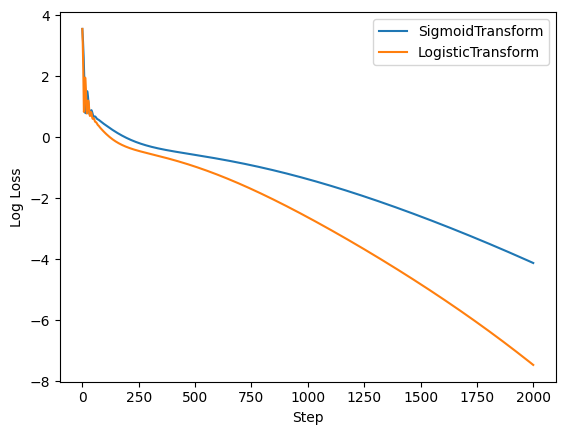

In [45]:
key = jax.random.PRNGKey(0)

def draw_uniform(key, lb, ub):
    return lb + (ub - lb) * jax.random.uniform(key)

bounds = {
    "HH_gNa": (100.0 * 1e-3, 200.0 * 1e-3),
    "HH_gK": (20.0 * 1e-3, 40.0 * 1e-3),
    "HH_gLeak": (0.01 * 1e-3, 0.5 * 1e-3),
}
comp.delete_trainables()
for k, (lb, ub) in bounds.items():
    key, subkey = jax.random.split(key, 2)
    comp.make_trainable(k, draw_uniform(subkey, lb, ub).item())

for leaf_tf in [SigmoidTransform, LogisticTransform]:
    print(f"Training run with {leaf_tf.__name__}")
    tf = ParamTransform([{k: leaf_tf(lb, ub)} for k, (lb, ub) in bounds.items()])

    def loss(params):
        _params = tf.forward(params)
        v = jx.integrate(comp, _params)[0, ::4]
        return jnp.mean((v - v_target) ** 2)

    grad_fn = jax.jit(jax.value_and_grad(loss, argnums=0))

    opt_params = comp.get_parameters()
    opt_params = tf.inverse(opt_params)

    # Define the optimizer.
    optimizer = optax.adam(learning_rate=1e-2)
    opt_state = optimizer.init(opt_params)

    losses = []
    for step in range(2000):
        loss, gradient = grad_fn(opt_params)
        losses.append(loss)

        # Optimizer step.
        updates, opt_state = optimizer.update(gradient, opt_state)
        opt_params = optax.apply_updates(opt_params, updates)

        if step % 100 == 0:
            print(f"Step {step}: Loss = {loss:.6f}")
    plt.plot(jnp.log(jnp.array(losses)), label=leaf_tf.__name__)
plt.xlabel("Step")
plt.ylabel("Log Loss")
plt.legend()
plt.show()
